# Introduciton

Given the outputs from the `drug_sensitivity_training.ipynb` I decided to go forward with optimizing `ElasticNetRegressor` model from `sci-kitlearn` library. I will optimize it using `optuna` and will try to better understand what are the signals learnt from the data using `shap` library.

## Imports, data loading and preprocessing

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import optuna
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting up pandas printing options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None) 

# Setting up working environment
base_path = Path.cwd()
os.chdir(base_path)

# Print out the current working directory
print(base_path)

/Users/ferenc.kagan/Documents/Projects/Archive/Turbine_hw


In [30]:
# Setting up multi-threading
OMP_NUM_THREADS=1
MKL_NUM_THREADS=1
OPENBLAS_NUM_THREADS=1
BLIS_NUM_THREADS=1

In [31]:
# Read in the provided data
print("Read in data...")


# Gene expression dataset
expr = pd.read_csv("input/CCLE_expression.csv")

# Metadata of the samples
metadata = pd.read_csv("input/sample_info.csv")

#Drug sensitivity data
sens = pd.read_excel("input/GDSC2_fitted_dose_response_25Feb20.xlsx")

Read in data...


In [32]:
# Prepare data for downstream analysis
print("Data wrangling...")

metadata = metadata[metadata['DepMap_ID'].isin(expr['Unnamed: 0'])]
metadata = metadata.set_index('DepMap_ID').reindex(expr['Unnamed: 0']).reset_index()

# Bring together all tables into singular giant table
merged_df = expr.merge(metadata, left_on='Unnamed: 0', right_on='Unnamed: 0').merge(sens[sens['DRUG_NAME'] == 'Lapatinib'], left_on='Sanger_Model_ID', right_on='SANGER_MODEL_ID')

# Replace unknown sex with NaN to be imputed
merged_df.loc[merged_df["sex"] == "Unknown", "sex"] = np.nan

Data wrangling...


In [33]:
# Extract relevant columns
categorical_cols = ['primary_disease', 'sex']
numerical_cols = ['age']  # Keep age numeric

# One-hot encode categorical features
subset_df = merged_df.iloc[:, 1:(expr.shape)[1]]
subset_df = pd.concat([subset_df, merged_df[categorical_cols + numerical_cols]], axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(subset_df, merged_df['LN_IC50'], test_size=0.2, random_state=17)

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('variancethreshold', VarianceThreshold(threshold=0.02)),
            ('scaler', StandardScaler())
        ]), X_train.columns[:-3]),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols),  
        
        ('age', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age'])
    ]
)

In [34]:
# Phase 2: Hyperparameter optimization
print("Hyperparameter optimization...")

# Define Optuna optimization function
def objective(trial):
    model = ElasticNet(
        alpha=trial.suggest_float("alpha", 0.1, 10.0),
        l1_ratio=trial.suggest_float("l1_ratio", 0.0, 1.0)
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return np.mean(cross_val_score(pipeline, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))


# Create an Optuna study
study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=100, n_jobs=15)

# Get the best trial
print(f"Best model: {study.best_trial.params}")
print(f"Best score: {-study.best_value}") # Convert back to positive MSE

[I 2025-03-07 10:38:29,136] A new study created in memory with name: no-name-9da3f6ea-3763-4f8a-9729-61f60932ce77


Hyperparameter optimization...


[I 2025-03-07 10:38:56,029] Trial 12 finished with value: -2.6784478689053257 and parameters: {'alpha': 2.489790766330089, 'l1_ratio': 0.5869653033562375}. Best is trial 12 with value: -2.6784478689053257.
[I 2025-03-07 10:38:56,106] Trial 10 finished with value: -2.6784478689053257 and parameters: {'alpha': 6.21467619894663, 'l1_ratio': 0.87853598196109}. Best is trial 12 with value: -2.6784478689053257.
[I 2025-03-07 10:38:56,226] Trial 3 finished with value: -2.6784478689053257 and parameters: {'alpha': 3.4424695089347237, 'l1_ratio': 0.21264716930249017}. Best is trial 12 with value: -2.6784478689053257.
[I 2025-03-07 10:38:56,466] Trial 0 finished with value: -2.6784478689053257 and parameters: {'alpha': 4.745864841106791, 'l1_ratio': 0.17126574802568262}. Best is trial 12 with value: -2.6784478689053257.
[I 2025-03-07 10:38:56,571] Trial 8 finished with value: -2.6784478689053257 and parameters: {'alpha': 8.911985430572607, 'l1_ratio': 0.6568390656382791}. Best is trial 12 with v

Best model: {'alpha': 2.067220938470626, 'l1_ratio': 0.037301577574481604}
Best score: 2.141755659609545


In [36]:
# --- Train the best model ---
best_params = study.best_trial.params
# Create a pipeline that includes preprocessing and the best model
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('model', ElasticNet(**best_params))  # Use the best ElasticNet model
])

# Fit the pipeline on the training data
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('variancethreshold',
                                                                   VarianceThreshold(threshold=0.02)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['TSPAN6 (7105)', 'TNMD (64102)', 'DPM1 (8813)', 'SCYL3 (57147)',
       'C1orf112 (55732)', 'FGR (2268)', 'CFH (3075)', 'FUCA2 (2519)',
       'GCLC (2729)', 'NFYA (4800)',
       ...
       'ARHGAP11B (89839)', 'AC004593...
      dtype='object', length=19177)),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['primary_disease', 'sex']),
                                                 ('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age'])])),
                ('model',
                 ElasticNet(alpha=2.067220938470626,
                            l1_ratio=0.037301577574481604))])

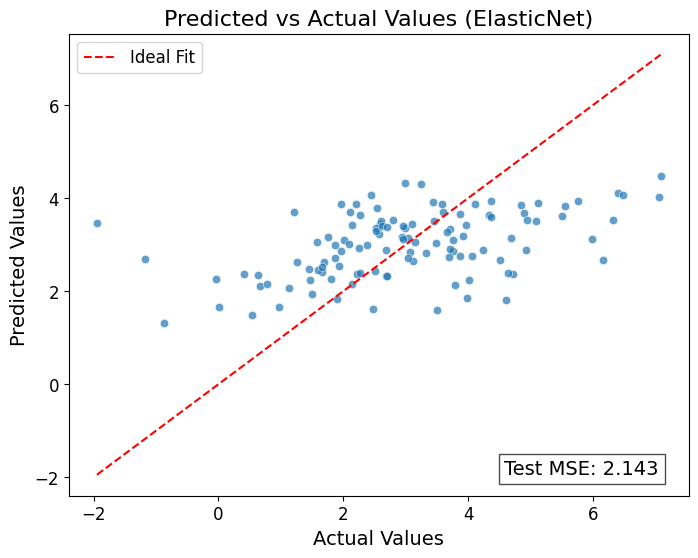

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Predict on the test set
y_pred = final_pipeline.predict(X_test)  # Now using the pipeline with preprocessing

# Calculate test MSE
test_mse = mean_squared_error(y_test, y_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)

# 1:1 reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal Fit")

# Increase font size
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.title("Predicted vs Actual Values (ElasticNet)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate MSE correctly
plt.text(
    y_test.max()-2.5, y_test.min(),  # Coordinates (X, Y)
    f"Test MSE: {test_mse:.3f}",  # Text string
    fontsize=14, color='black',  # Formatting
    bbox=dict(facecolor='white', alpha=0.7)  # Background box
)

plt.legend(fontsize=12)
plt.show()